# Exercise 4: Vocoder and Quantization

In [1]:
from typing import Tuple

import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, lfilter
from scipy.linalg import solve_toeplitz
from IPython.display import Audio


%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 4)

In [2]:
# "Import" functions from previous exercises

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
        "my_windowing",
        "acf",
        "estimate_fundamental_frequency",
    ],
)
import_function_from_ipynb(
    "exercise2.ipynb",
    [
        "compute_stft",
    ]
)
import_function_from_ipynb(
    "exercise3.ipynb",
    [
        "estimate_filter",
        "plot_dft",
    ]
)

Downloaded import_funcs.py
Found exercise1.ipynb: C:\Users\Natia_Mestvirishvili\Desktop\UHH\SSP\ssp_sose2023\Exercise1\exercise1.ipynb
Executed function plot_signal
Executed function my_windowing
Executed function acf
Executed function estimate_fundamental_frequency
Successfully imported functions: ['plot_signal', 'my_windowing', 'acf', 'estimate_fundamental_frequency']
Found exercise2.ipynb: C:\Users\Natia_Mestvirishvili\Desktop\UHH\SSP\ssp_sose2023\Exercise2\exercise2.ipynb
Executed function compute_stft
Successfully imported functions: ['compute_stft']
Found exercise3.ipynb: C:\Users\Natia_Mestvirishvili\Desktop\UHH\SSP\ssp_sose2023\Exercise3\exercise3.ipynb
Executed function estimate_filter
Executed function plot_dft
Successfully imported functions: ['estimate_filter', 'plot_dft']


In [3]:
def plot_log_spectrogram(
    signal: np.ndarray,
    sampling_rate: int,
    frame_length: int = 32,
    frame_shift: int = 8,
    max_freq: int = 8000,
    fig: plt.Figure = None,
    ax: plt.Axes = None,
) -> None:
    """Plot the log spectrogram of a signal."""
    m_stft, v_freq, v_time = compute_stft(
        signal,
        sampling_rate,
        frame_length,
        frame_shift,
        get_window("hann", frame_length * sampling_rate // 1000),
    )

    magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15)))

    # limit frequency range to [0, max_freq]
    v_freq = v_freq[v_freq <= max_freq]
    magnitude = magnitude[: len(v_freq), :]

    if fig is None and ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    im = ax.imshow(
        magnitude,
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )

    # fig.colorbar(im, orientation="vertical", pad=0.01)
    # im.colorbar.set_label("Magnitude [dB]", rotation=270, labelpad=15)

    # ax.set_title(f"Spectrogram \n (frame length: {frame_length} ms, frame shift: {frame_shift} ms)")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_ylim(0, max_freq)
    # ax.set_yscale("log")

## 2.1 Load `female8khz.wav`

In [4]:
x, fs = librosa.core.load("Audio/female8khz.wav", sr=None)
print(f"Samples: {len(x)}, sampling frequency: {fs} Hz")

Samples: 18000, sampling frequency: 8000 Hz


In [5]:
print("Signal")
Audio(x, rate=fs)

Signal


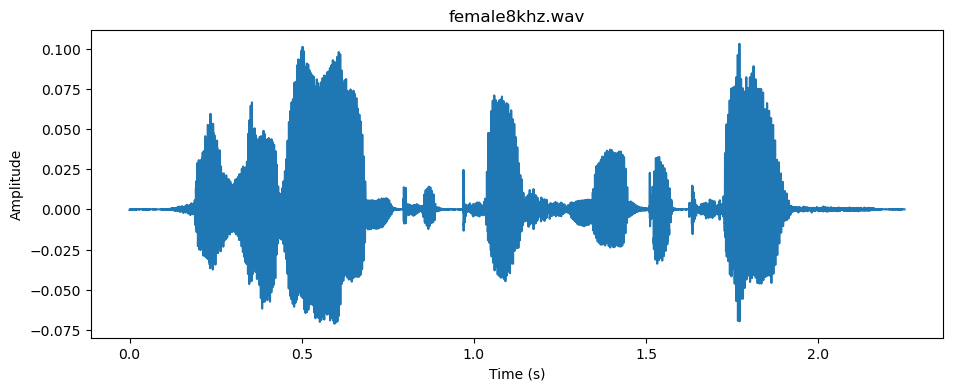

In [6]:
plot_signal(x, fs, title="female8khz.wav")

In [7]:
# Window the signal
frame_length = 32 # ms
frame_shift = 8 # ms
N = frame_length * fs // 1000
R = frame_shift * fs // 1000
print(f"Frame length: {N} samples, frame shift: {R} samples")

m_frames, v_time_frame = my_windowing(x, fs, frame_length, frame_shift)
m_frames.shape, v_time_frame.shape

Frame length: 256 samples, frame shift: 64 samples


((278, 256), (278,))

- Why do we segment the signal prior to analysis instead of processing the whole signal at once?
  - Because the signal is not stationary, and the analysis is only valid for a short period of time.
- Is a segment length of 32 ms appropriate? Why or why not?
  - It provides a reasonable trade-off between frequency and time resolution.

## 2.2 Signal power

In [8]:
def compute_power(x: np.ndarray) -> float:
    return np.sum(x ** 2) / len(x)

In [9]:
# Compute power of each frame
v_power = np.apply_along_axis(compute_power, 1, m_frames)
v_power.shape

(278,)

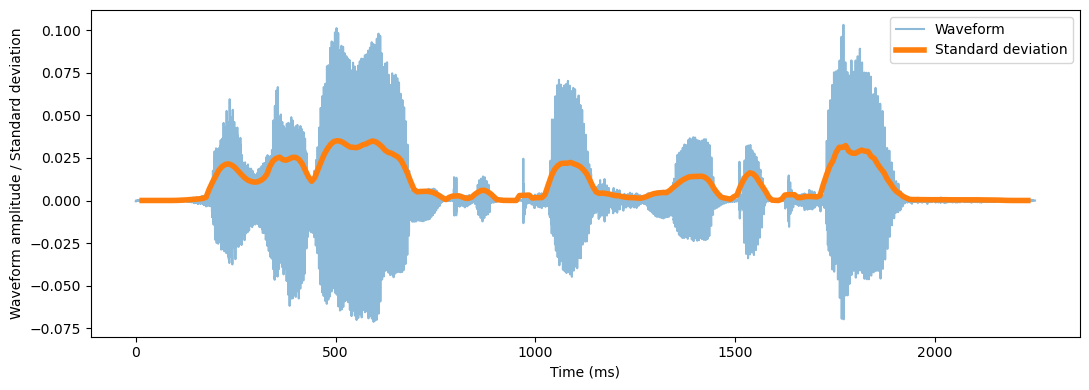

In [10]:
# Plot waveform and standard deviation
plt.plot(np.arange(len(x)) / fs * 1000, x, alpha=0.5, label="Waveform")
plt.plot(v_time_frame, np.sqrt(v_power), linewidth=4, label="Standard deviation")
plt.xlabel("Time (ms)")
plt.ylabel("Waveform amplitude / Standard deviation")
plt.tight_layout()
plt.legend()
plt.show()

## 2.3 Voiced / unvoiced decision

- Explain differences in the creation of speech for voiced and unvoiced sounds.
  - Voiced sounds are created by the vibration of the vocal folds, which creates a quasi-periodic signal. Unvoiced sounds are created by turbulent air flow, which creates a random signal.
- Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?
  - Since voiced sounds are quasi-periodic, they have a lower number of zero crossings. Unvoiced sounds are random and contain higher-frequency components, they have a higher number of zero crossings.
- Think of a way how you can efficiently detect a zero crossing between two samples. How can you realize that in
Python?
   - The sign of the two consecutive samples is different if there is a zero crossing. We could multiply the two samples and check if the result is negative.

In [11]:
def plot_signal_and_zero_crossings(x: np.ndarray, title: str = ""):
    signs = np.sign(x)
    zero_crossings = signs * np.roll(signs, 1) < 0
    zero_crossings = np.where(zero_crossings)[0]

    plt.plot(x, label="Frame")
    plt.plot(zero_crossings, np.zeros(len(zero_crossings)), ".", c="red", label="Zero crossings")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.title(title + f" ({len(zero_crossings)} zero crossings)")
    
    # clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

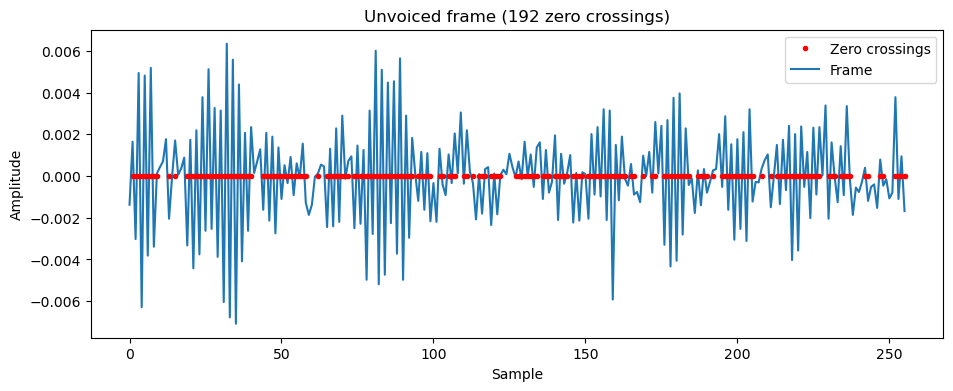

In [12]:
plot_signal_and_zero_crossings(m_frames[150], title="Unvoiced frame")

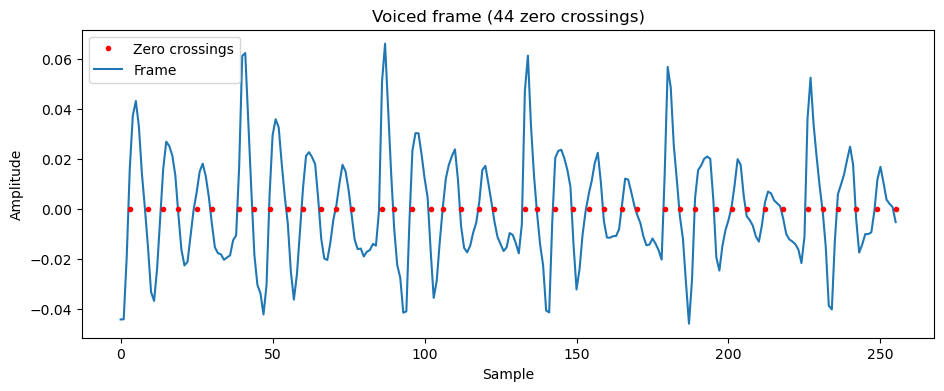

In [13]:
plot_signal_and_zero_crossings(m_frames[230], title="Voiced frame")

In [14]:
def n_zero_crossings(x: np.ndarray) -> int:
    signs = np.sign(x)
    zero_crossings = signs * np.roll(signs, 1) < 0
    return np.sum(zero_crossings) / N

In [15]:
def is_voiced(x: np.ndarray, threshold: float) -> int:
    """Return 1 for voiced, 0 for unvoiced."""
    return 1 if n_zero_crossings(x) < threshold else 0

In [16]:
# Threshold on number of zero crossings per sample
threshold = 0.29

v_voiced = np.apply_along_axis(is_voiced, 1, m_frames, threshold)
v_voiced.shape

(278,)

Output matches np.fft.rfft: True


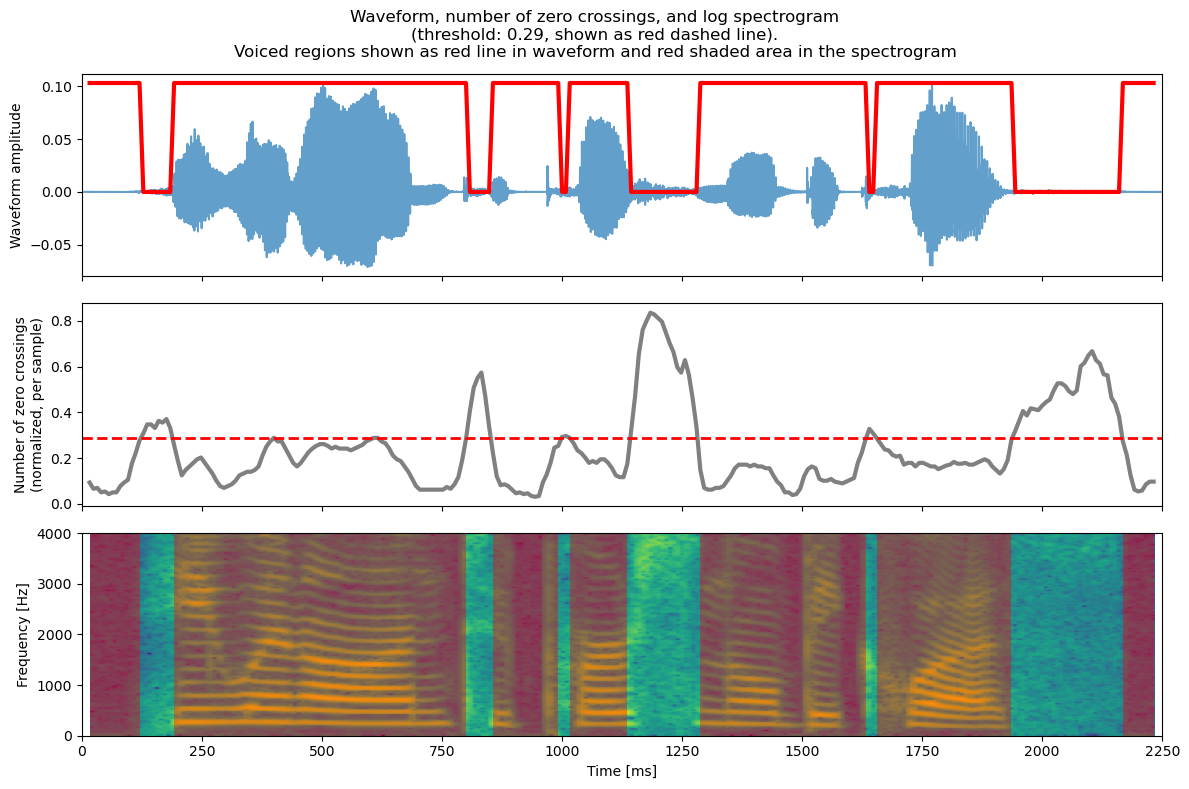

In [17]:
# Plot waveform and number of zero crossings
max_ms = len(x) / fs * 1000

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(np.arange(len(x)) / fs * 1000, x, alpha=0.7)
axs[0].plot(v_time_frame, v_voiced * np.max(x), linewidth=3, c="red", label="Voiced")
axs[0].set_ylabel("Waveform amplitude")
axs[0].set_xlim(0, max_ms)

axs[1].plot(v_time_frame, np.apply_along_axis(n_zero_crossings, 1, m_frames), linewidth=3, c="gray")
axs[1].axhline(threshold, c="red", linestyle="--", linewidth=2)
axs[1].set_ylabel(f"Number of zero crossings\n(normalized, per sample)")
axs[1].set_xlim(0, max_ms)

max_freq = 4000
plot_log_spectrogram(x, fs, frame_length, frame_shift, max_freq=max_freq, fig=fig, ax=axs[2])
# plot v_voiced as red shaded area in spectrogram
axs[2].fill_between(
    v_time_frame,
    0,
    max_freq,
    where=v_voiced == 1,
    facecolor="red",
    alpha=0.4,
    transform=axs[2].get_xaxis_transform(),
)

fig.suptitle(
    f"Waveform, number of zero crossings, and log spectrogram\n"
    f"(threshold: {threshold}, shown as red dashed line).\n"
    "Voiced regions shown as red line in waveform and red shaded area in the spectrogram"
)
plt.tight_layout()

- In general: are all speech sounds either voiced or unvoiced? Can you think of other speech sounds? Examples?
  - TODO

## 2.4 Fundamental frequency estimation

In [18]:
v_f0_estimates = estimate_fundamental_frequency(acf(m_frames), fs)
v_f0_estimates.shape

(278,)

Plot f0 estimate together with spectrogram

Output matches np.fft.rfft: True


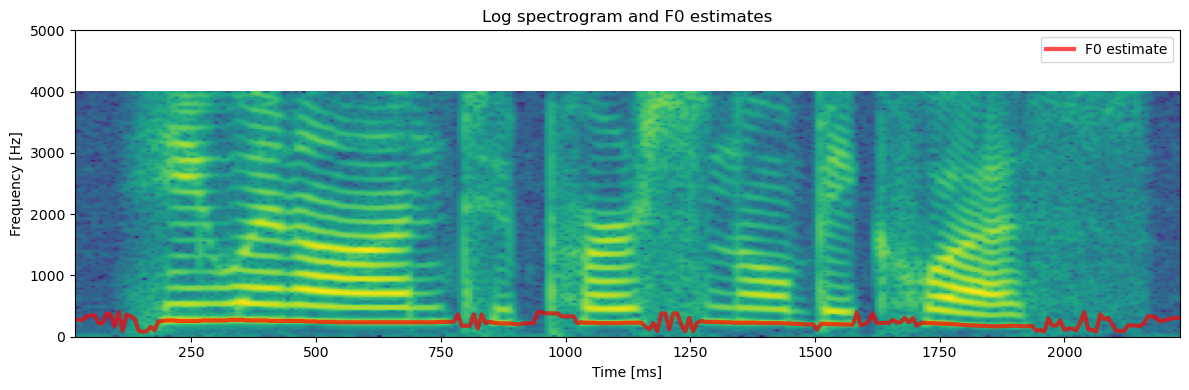

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_log_spectrogram(x, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=ax)
ax.plot(v_time_frame, v_f0_estimates, linewidth=3, c="red", alpha=0.7, label="F0 estimate")
ax.legend()
ax.set_title("Log spectrogram and F0 estimates")
plt.tight_layout()

## 2.5 LPC

- Shortly outline the source-filter model for speech production
  - TODO

In [20]:
# Compute the LPCs
def compute_lpc(m_frames: np.ndarray, M: int) -> np.ndarray:
    """Compute linear prediction coefficients for each segment"""
    m_lpc = np.zeros((len(m_frames), M))
    for i, frame in enumerate(m_frames):
        m_lpc[i] = estimate_filter(frame, M)
    return m_lpc

TODO: choose suitable M and explain reasoning

In [21]:
LPC_ORDER = 12

m_lpc = compute_lpc(m_frames, M=LPC_ORDER)
m_lpc.shape

(278, 12)

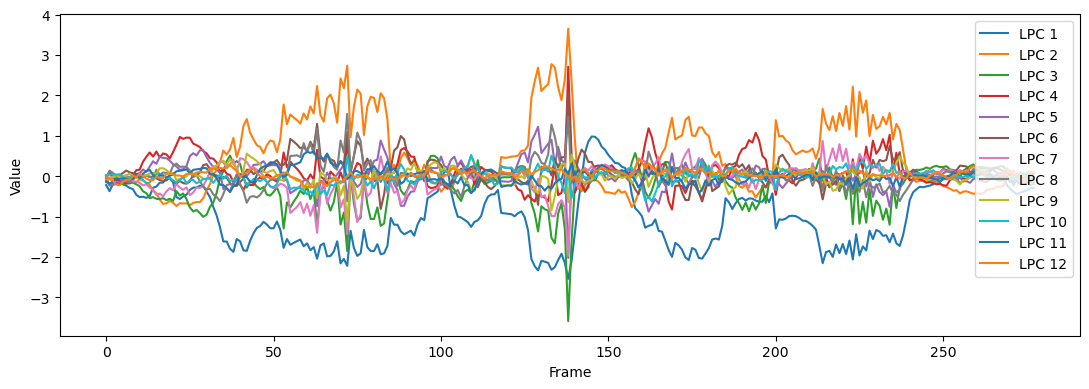

In [22]:
# Plot the LPCs
for i in range(m_lpc.shape[1]):
    plt.plot(m_lpc[:, i], label=f"LPC {i+1}")
plt.ylabel("Value")
plt.xlabel("Frame")
plt.legend()
plt.tight_layout()

# 3 LPC-vocoder: synthesis

## 3.1 LPCs and constant excitation signal

In [23]:
# generate excitation signals
num_samples = len(m_frames) * R
voiced_fund_freq = 100 # Hz

voiced_ex = np.zeros(num_samples)
voiced_ex[::int(fs / voiced_fund_freq)] = 1

unvoiced_ex = np.random.randn(num_samples)

voiced_ex.shape, unvoiced_ex.shape

((17792,), (17792,))

In [24]:
# segment each signal into non-overlapping frames of length R
voiced_ex_frames = voiced_ex.reshape(-1, R)
unvoiced_ex_frames = unvoiced_ex.reshape(-1, R)

voiced_ex_frames.shape, unvoiced_ex_frames.shape

((278, 64), (278, 64))

In [25]:
from ex4_lib.filteradaptively import filter_adaptively

In [26]:
def filter_frames(frames: np.ndarray, lpcs: np.ndarray) -> np.ndarray:
    segment_out = np.zeros_like(frames)
    filter_state = None
    for i in range(len(frames)):
        segment_out[i], filter_state = filter_adaptively(
            [1],
            np.concatenate(([1], lpcs[i])),
            frames[i],
            filter_state,
        )
    return segment_out

In [27]:
filter_frames(voiced_ex_frames, m_lpc).shape

(278, 64)

In [28]:
# Put together segments to obtain the whole signal
voiced_out = filter_frames(voiced_ex_frames, m_lpc).flatten()
unvoiced_out = filter_frames(unvoiced_ex_frames, m_lpc).flatten()

voiced_out.shape, unvoiced_out.shape

((17792,), (17792,))

In [29]:
print("Voiced")
Audio(voiced_out, rate=fs)

Voiced


In [30]:
print("Unvoiced")
Audio(unvoiced_out, rate=fs)

Unvoiced


Output matches np.fft.rfft: True
Output matches np.fft.rfft: True


Text(0.5, 1.0, 'Unvoiced')

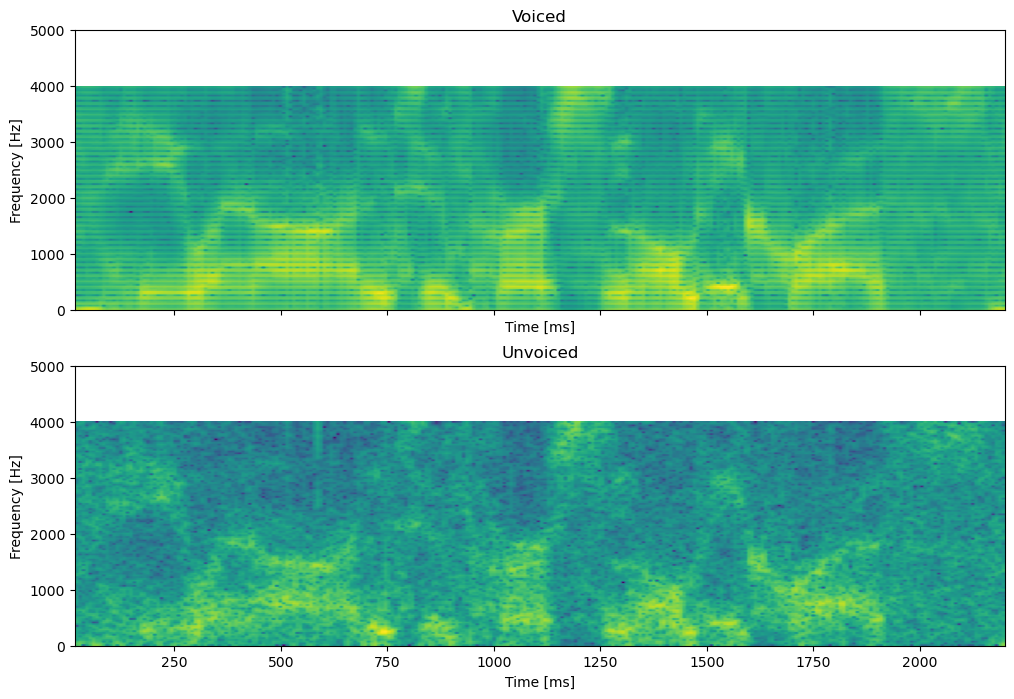

In [31]:
# Plot spectrogram of the synthesized signals

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_log_spectrogram(voiced_out, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[0])
axs[0].set_title("Voiced")

plot_log_spectrogram(unvoiced_out, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[1])
axs[1].set_title("Unvoiced")

## 3.2 Voiced / unvoiced excitation

In [32]:
# Switch between voiced and unvoiced e based on v_voiced
switched_ex_frames = np.where(v_voiced[:, None], voiced_ex_frames, unvoiced_ex_frames)

total_frames = filter_frames(switched_ex_frames, m_lpc)

In [33]:
print("Switched")
Audio(total_frames.flatten(), rate=fs)

Switched


## 3.3 Amplitude modulation

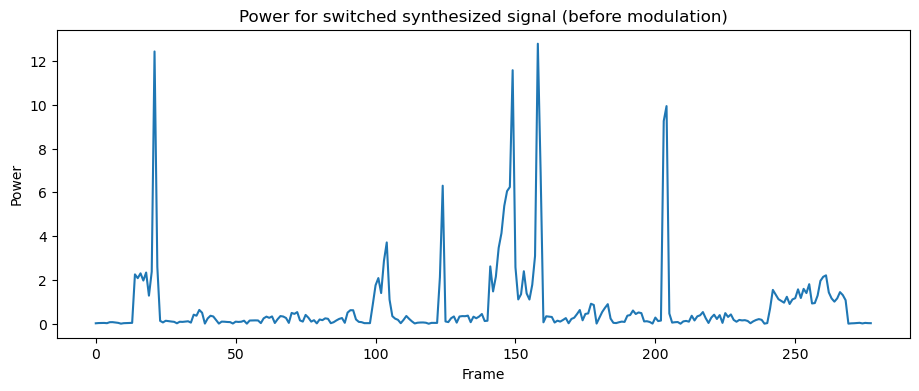

In [34]:
v_power_switched = np.apply_along_axis(compute_power, 1, total_frames)

plt.plot(v_power_switched)
plt.xlabel("Frame")
plt.ylabel("Power")
plt.title("Power for switched synthesized signal (before modulation)")
plt.show()

In [35]:
power_clip = 0.01

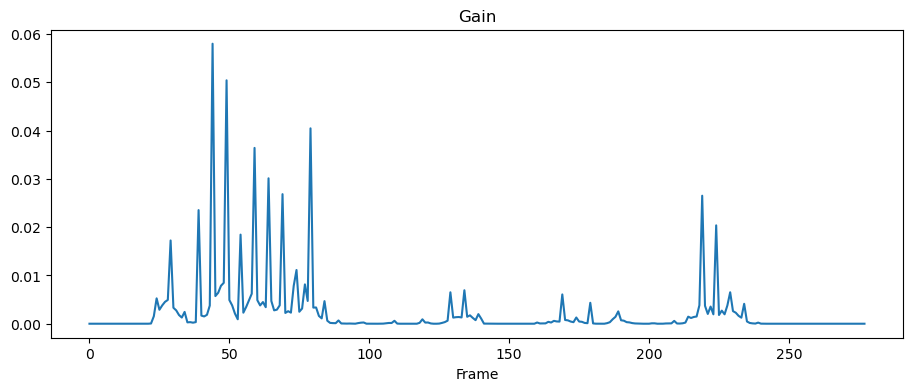

In [36]:
# Compute gain
g = v_power / np.clip(v_power_switched, power_clip, a_max=None)

plt.plot(g)
plt.xlabel("Frame")
plt.title("Gain")
plt.show()

In [37]:
# Apply gain
total_frames_modulated = np.sqrt(g[:, None]) * total_frames

In [38]:
print("Switched and modulated")
Audio(total_frames_modulated.flatten(), rate=fs)

Switched and modulated


- What is the improvement achieved by applying g?
  - TODO

Output matches np.fft.rfft: True


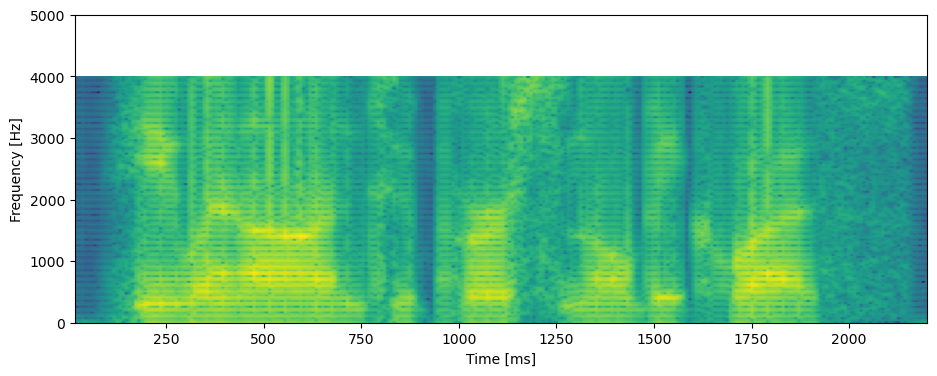

In [39]:
plot_log_spectrogram(total_frames_modulated.flatten(), fs, frame_length, frame_shift, max_freq=5000)

## 3.4 Variable $f_0$

In [40]:
def synthesize_signal(
    v_voiced: np.ndarray,
    v_f0: np.ndarray,
    v_input_power: np.ndarray,
    m_lpc: np.ndarray = None,
):
    
    # generate excitation signals
    num_samples = len(v_voiced) * R
    unvoiced_ex = np.random.randn(num_samples)

    voiced_ex = np.zeros(num_samples)
    counter = 0
    for i in range(num_samples):
        cur_fund_period_samples = int(fs / v_f0[i // R])
        if counter > cur_fund_period_samples:
            voiced_ex[i] = 1
            counter = 0
        else:
            counter += 1

    # segment each signal into non-overlapping frames of length R
    voiced_ex_frames = voiced_ex.reshape(-1, R)
    unvoiced_ex_frames = unvoiced_ex.reshape(-1, R)

    # switch between voiced and unvoiced e based on v_voiced
    switched_ex_frames = np.where(v_voiced[:, None], voiced_ex_frames, unvoiced_ex_frames)
    if m_lpc is not None:
        total_frames = filter_frames(switched_ex_frames, m_lpc)
    else:
        total_frames = switched_ex_frames

    v_power_switched = np.apply_along_axis(compute_power, 1, total_frames)
    g = v_input_power / np.clip(v_power_switched, power_clip, a_max=None)
    total_frames_modulated = np.sqrt(g[:, None]) * total_frames

    return total_frames_modulated.flatten()

In [41]:
synth_s = synthesize_signal(
    v_voiced,
    v_f0_estimates,
    v_power,
    m_lpc,
)
synth_s.shape

(17792,)

In [42]:
print("Synthesized with variable f0")
Audio(synth_s, rate=fs)

Synthesized with variable f0


Output matches np.fft.rfft: True
Output matches np.fft.rfft: True


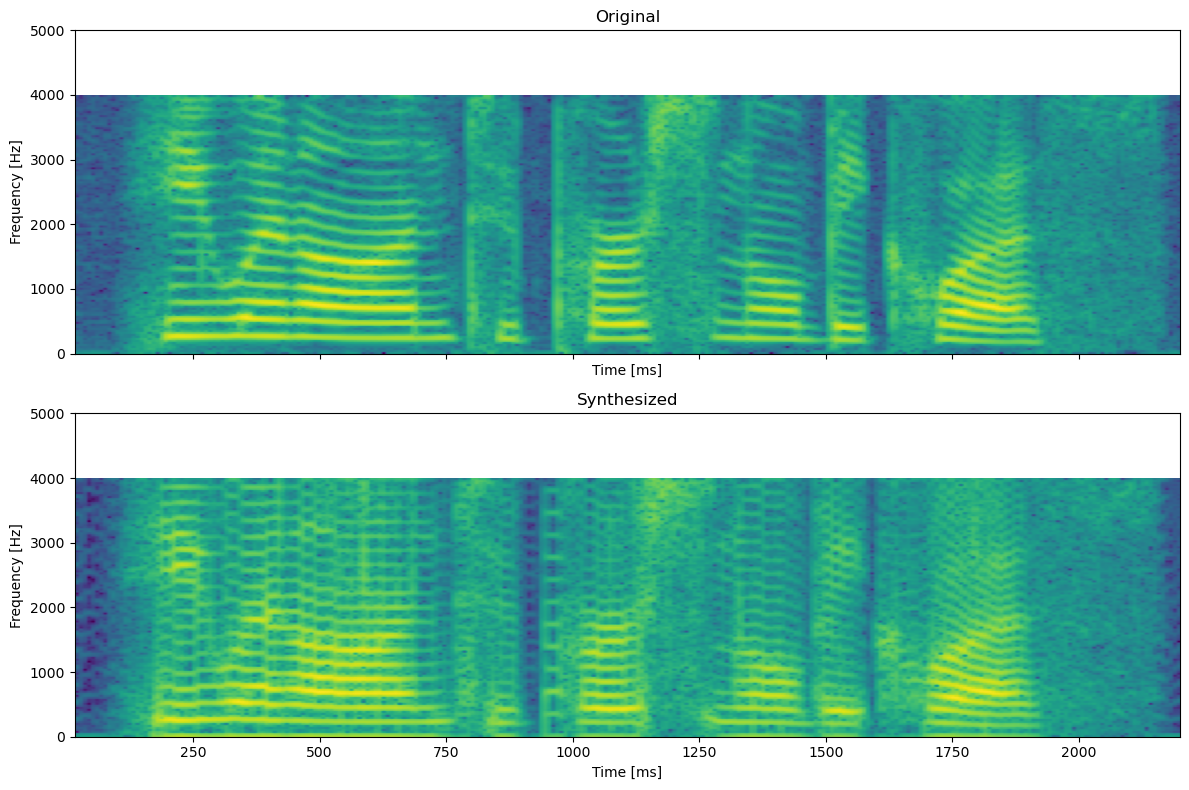

In [43]:
# Plot spectrograms of the synthesized and original signals
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_log_spectrogram(x, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[0])
axs[0].set_title("Original")

plot_log_spectrogram(synth_s, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[1])
axs[1].set_title("Synthesized")

fig.tight_layout()

## 3.5 No LPC

In [44]:
synth_s_no_lpc = synthesize_signal(
    v_voiced,
    v_f0_estimates,
    v_power,
    m_lpc=None,
)

In [45]:
print("Synthesized with no LPC")
Audio(synth_s_no_lpc, rate=fs)

Synthesized with no LPC


Output matches np.fft.rfft: True
Output matches np.fft.rfft: True


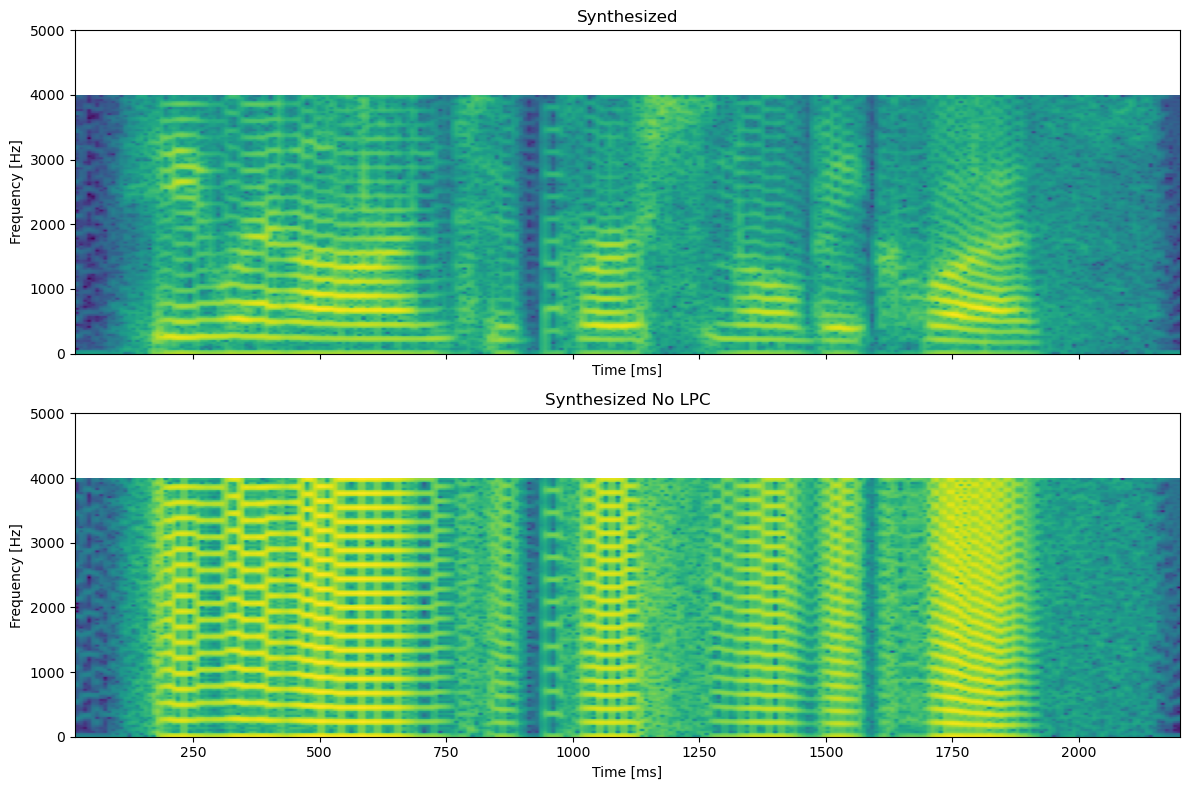

In [46]:
# Plot spectrograms of the synthesized and original signals
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_log_spectrogram(synth_s, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[0])
axs[0].set_title("Synthesized")

plot_log_spectrogram(synth_s_no_lpc, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[1])
axs[1].set_title("Synthesized No LPC")

fig.tight_layout()

TODO: experiments

# 4 Quantization

## 4.1 Uniform scalar quantizer

In [47]:
def quantize_encoder(
    x: np.ndarray,
    num_bits: int,
    x_range: float,
    x_center: float,
) -> np.ndarray:
    num_levels = 2 ** num_bits
    step_size = x_range / num_levels

    lower_bound = x_center - x_range / 2
    upper_bound = x_center + x_range / 2

    quant_idxs = np.clip(x, lower_bound, upper_bound - 1e-6)
    quant_idxs -= lower_bound
    quant_idxs /= step_size
    quant_idxs = np.floor(quant_idxs).astype(int)

    return quant_idxs

In [48]:
def quantize_decoder(
    quant_idxs: np.ndarray,
    num_bits: int,
    x_range: float,
    x_center: float,
) -> np.ndarray:
    num_levels = 2 ** num_bits
    step_size = x_range / num_levels

    lower_bound = x_center - x_range / 2

    x = quant_idxs * step_size + lower_bound + step_size / 2

    return x

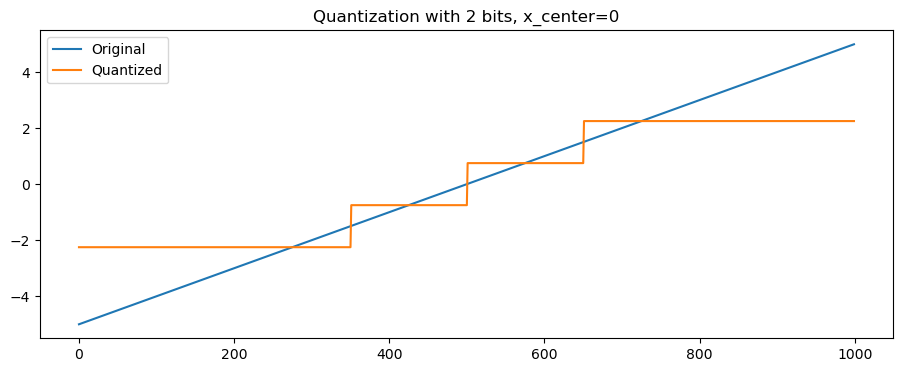

In [49]:
# Test with a ramp function (-5:0.01:5)
quant_test_x = np.arange(-5, 5, 0.01)

# Encode
quant_idxs = quantize_encoder(quant_test_x, num_bits=2, x_range=6, x_center=0)

# Decode
quant_test_x_hat = quantize_decoder(quant_idxs, num_bits=2, x_range=6, x_center=0)

# Plot both
plt.title(f"Quantization with 2 bits, x_center=0")
plt.plot(quant_test_x, label="Original")
plt.plot(quant_test_x_hat, label="Quantized")
plt.legend()
plt.show()

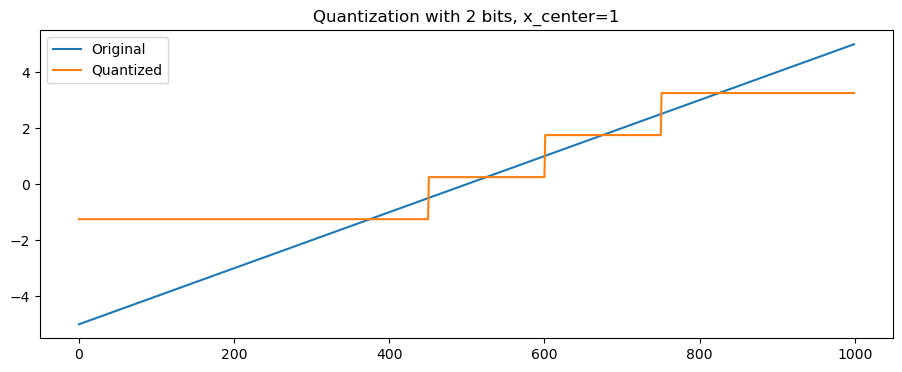

In [50]:
# Encode
quant_idxs = quantize_encoder(quant_test_x, num_bits=2, x_range=6, x_center=1)

# Decode
quant_test_x_hat = quantize_decoder(quant_idxs, num_bits=2, x_range=6, x_center=1)

# Plot both
plt.title(f"Quantization with 2 bits, x_center=1")
plt.plot(quant_test_x, label="Original")
plt.plot(quant_test_x_hat, label="Quantized")
plt.legend()
plt.show()

## 4.2 Quantizing the fundamental frequency

In [51]:
def find_center_and_range(x: np.ndarray) -> Tuple[float, float]:
    x_center = (x.max() + x.min()) / 2
    x_range = x.max() - x.min()
    return x_center, x_range

In [52]:
f0_center, f0_range = find_center_and_range(v_f0_estimates)

print(f"Min: {v_f0_estimates.min()}, Max: {v_f0_estimates.max()}")
print(f"Center: {f0_center}, Range: {f0_range}")

Min: 82.47422680412372, Max: 400.0
Center: 241.23711340206185, Range: 317.5257731958763


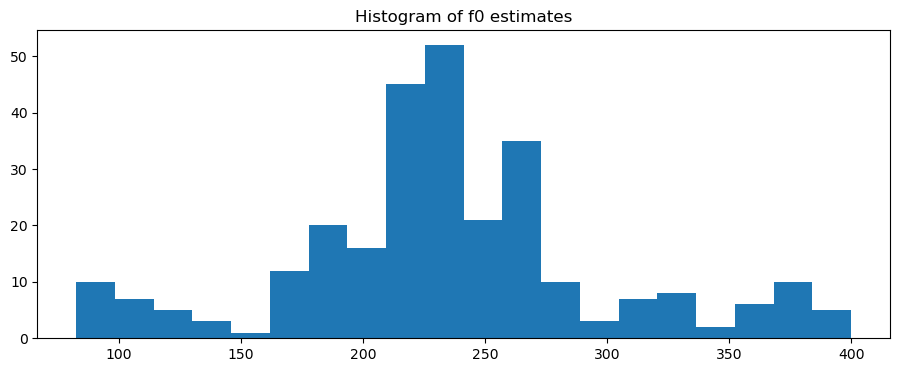

In [53]:
plt.hist(v_f0_estimates, bins=20)
plt.title("Histogram of f0 estimates")
plt.show()

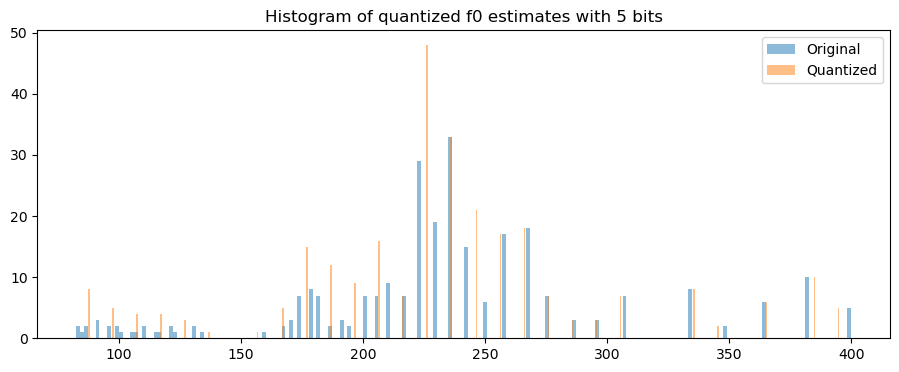

In [74]:
n_bits_f0 = 5

v_f0_estimates_quant = quantize_encoder(v_f0_estimates, num_bits=n_bits_f0, x_range=f0_range, x_center=f0_center)
v_f0_estimates_hat = quantize_decoder(v_f0_estimates_quant, num_bits=n_bits_f0, x_range=f0_range, x_center=f0_center)

# Plot the histogram of original and quantized f0 estimates
plt.hist(v_f0_estimates, bins=200, alpha=0.5, label="Original")
plt.hist(
    v_f0_estimates_hat,
    bins=500,
    alpha=0.5,
    label="Quantized",
)
plt.title(f"Histogram of quantized f0 estimates with {n_bits_f0} bits")
plt.legend()
plt.show()

In [73]:
# Synthesize signal with quantized f0 estimates
synth_s_quant = synthesize_signal(
    v_voiced,
    v_f0_estimates_hat,
    v_power,
    m_lpc,
)

print(f"Synthesized with quantized f0 (n_bits={n_bits_f0})")
Audio(synth_s_quant, rate=fs)

Synthesized with quantized f0 (n_bits=5)


## 4.3 Quantizing the signal energy

In [56]:
power_center, power_range = find_center_and_range(v_power)

print(f"Min: {v_power.min()}, Max: {v_power.max()}")
print(f"Center: {power_center}, Range: {power_range}")

Min: 1.979060471057892e-09, Max: 0.0012351426994428039
Center: 0.0006175723392516375, Range: 0.0012351407203823328


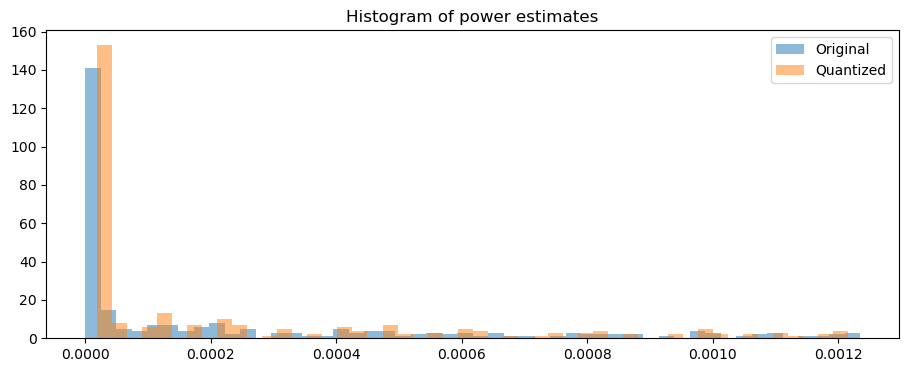

In [75]:
n_bits_power = 5

v_power_quant = quantize_encoder(v_power, num_bits=n_bits_power, x_range=power_range, x_center=power_center)
v_power_hat = quantize_decoder(v_power_quant, num_bits=n_bits_power, x_range=power_range, x_center=power_center)

plt.hist(v_power, bins=50, alpha=0.5, label="Original")
plt.hist(
    v_power_hat,
    bins=50,
    alpha=0.5,
    label="Quantized",
)
plt.title("Histogram of power estimates")
plt.legend()
plt.show()

Min: -20.040643614421978, Max: -6.6965687694696
Center: -13.368606191945789, Range: 13.344074844952377


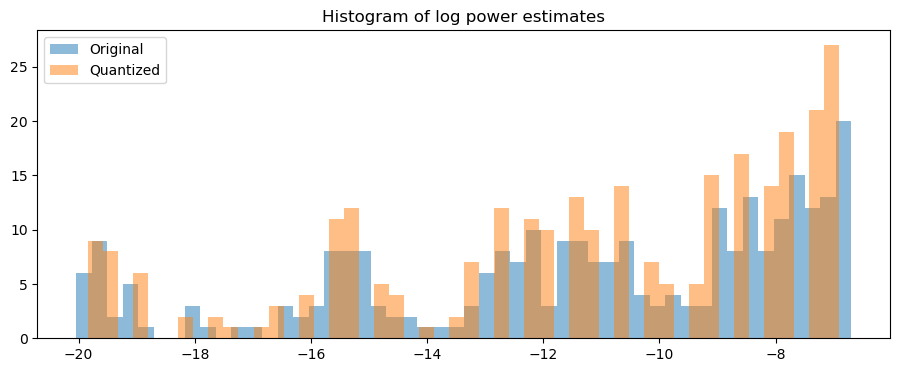

In [76]:
v_power_log = np.log(v_power)

power_log_center, power_log_range = find_center_and_range(v_power_log)

print(f"Min: {v_power_log.min()}, Max: {v_power_log.max()}")
print(f"Center: {power_log_center}, Range: {power_log_range}")

v_power_log_quant = quantize_encoder(v_power_log, num_bits=n_bits_power, x_range=power_log_range, x_center=power_log_center)

plt.hist(v_power_log, bins=50, alpha=0.5, label="Original")
plt.hist(
    quantize_decoder(
        v_power_log_quant,
        num_bits=n_bits_power,
        x_range=power_log_range,
        x_center=power_log_center,
    ),
    bins=50,
    alpha=0.5,
    label="Quantized",
)
plt.title("Histogram of log power estimates")
plt.legend()
plt.show()

Log quantization is better because of the long tail of the distribution.

In [78]:
# Synthesize signal with quantized power
synth_s_quant = synthesize_signal(
    v_voiced,
    v_f0_estimates,
    v_power_hat,
    m_lpc,
)

print(f"Synthesized with quantized power (n_bits={n_bits_power})")
Audio(synth_s_quant, rate=fs)

Synthesized with quantized power (n_bits=5)


## 4.4 Quantizing the LPCs

In [60]:
from ex4_lib.lpctools import poly2rc, rc2poly, rc2lar, lar2rc

In [61]:
# Convert LPC coefficients to reflection coefficients
m_rc = np.apply_along_axis(poly2rc, 1, np.hstack([np.ones((m_lpc.shape[0], 1)), m_lpc]))

# Convert reflection coefficients to log area ratios
m_lar = rc2lar(m_rc)

print(m_lar)

[[-0.86565787 -0.52242839 -0.23020328 ... -0.02073785 -0.26494064
  -0.06209988]
 [-1.44522304 -0.49445646 -0.50567238 ... -0.09604873 -0.43464035
  -0.13870344]
 [-1.33917248 -0.71187731 -0.57361034 ... -0.0085458  -0.32617963
  -0.22738295]
 ...
 [-1.37274139 -0.52190118 -0.41899933 ... -0.1266435  -0.43745298
  -0.21681876]
 [-1.1078931  -0.44435402 -0.46330379 ... -0.2333598  -0.39303663
  -0.32414297]
 [-1.05977246 -0.52579019 -0.41477622 ... -0.32264154 -0.25699029
  -0.17731887]]


Text(0.5, 1.0, 'Histogram of log area ratios')

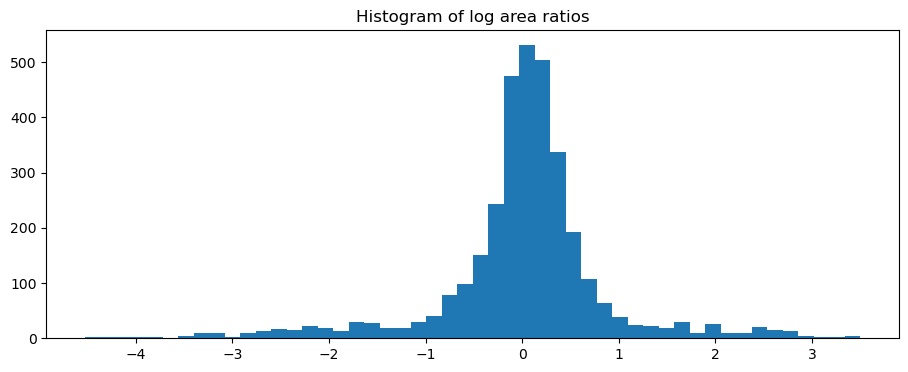

In [62]:
plt.hist(m_lar.flatten(), bins=50)
plt.title("Histogram of log area ratios")

In [63]:
lar_center, lar_range = find_center_and_range(m_lar.flatten())

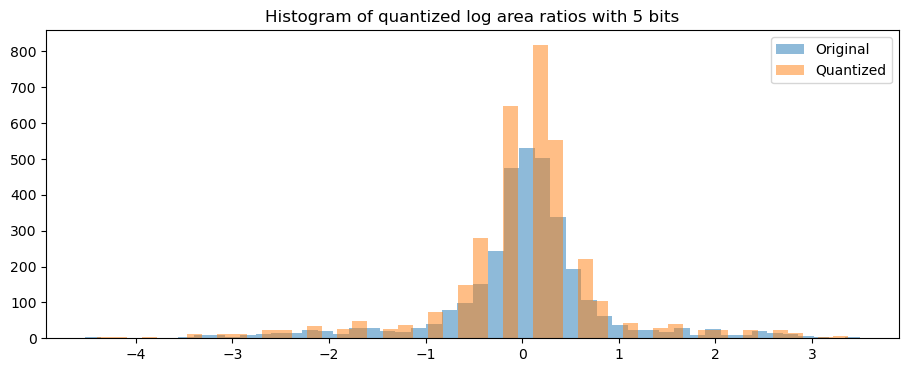

In [80]:
n_bits_lar = 5

m_lar_quant = quantize_encoder(m_lar, num_bits=n_bits_lar, x_range=lar_range, x_center=lar_center)
m_lar_hat = quantize_decoder(m_lar_quant, num_bits=n_bits_lar, x_range=lar_range, x_center=lar_center)

plt.hist(m_lar.flatten(), bins=50, alpha=0.5, label="Original")
plt.hist(
    m_lar_hat.flatten(),
    bins=50,
    alpha=0.5,
    label="Quantized",
)
plt.title(f"Histogram of quantized log area ratios with {n_bits_lar} bits")
plt.legend()
plt.show()

In [81]:
# Reconstruct m_lpc from m_lar_hat
m_rc_hat = lar2rc(m_lar_hat)
m_lpc_hat = np.apply_along_axis(rc2poly, 1, m_rc_hat)[:, 1:]
m_lpc_hat.shape

(278, 12)

In [82]:
# Synthesize signal with quantized power
synth_s_quant = synthesize_signal(
    v_voiced,
    v_f0_estimates,
    v_power_hat,
    m_lpc_hat,
)

print(f"Synthesized with quantized LPC (n_bits={n_bits_lar})")
Audio(synth_s_quant, rate=fs)

Synthesized with quantized LPC (n_bits=5)


### Full quantized pipeline

In [66]:
def synthesize_signal_quantized(v_voiced, v_f0_estimates, v_power, m_lpc, n_bits_f0, n_bits_power, n_bits_lar):
    f0_config = {"num_bits": n_bits_f0}
    f0_config["x_center"], f0_config["x_range"] = find_center_and_range(v_f0_estimates)
    v_f0_estimates_hat = quantize_decoder(
        quantize_encoder(v_f0_estimates, **f0_config),
        **f0_config,
    )

    power_config = {"num_bits": n_bits_power}
    power_config["x_center"], power_config["x_range"] = find_center_and_range(v_power)
    v_power_hat = quantize_decoder(
        quantize_encoder(v_power, **power_config),
        **power_config,
    )

    lar_config = {"num_bits": n_bits_lar}
    m_lar = rc2lar(np.apply_along_axis(poly2rc, 1, np.hstack([np.ones((m_lpc.shape[0], 1)), m_lpc])))
    lar_config["x_center"], lar_config["x_range"] = find_center_and_range(m_lar.flatten())
    m_lar_hat = quantize_decoder(
        quantize_encoder(m_lar, **lar_config),
        **lar_config,
    )
    m_rc_hat = lar2rc(m_lar_hat)
    m_lpc_hat = np.apply_along_axis(rc2poly, 1, m_rc_hat)[:, 1:]

    return synthesize_signal(
        v_voiced,
        v_f0_estimates_hat,
        v_power_hat,
        m_lpc_hat,
    )

In [84]:
s_synth_quant = synthesize_signal_quantized(
    v_voiced,
    v_f0_estimates,
    v_power,
    m_lpc,
    n_bits_f0=8,
    n_bits_power=8,
    n_bits_lar=10
)

print(f"Synthesized with quantization:")
Audio(s_synth_quant, rate=fs)

Synthesized with quantization:


Output matches np.fft.rfft: True
Output matches np.fft.rfft: True


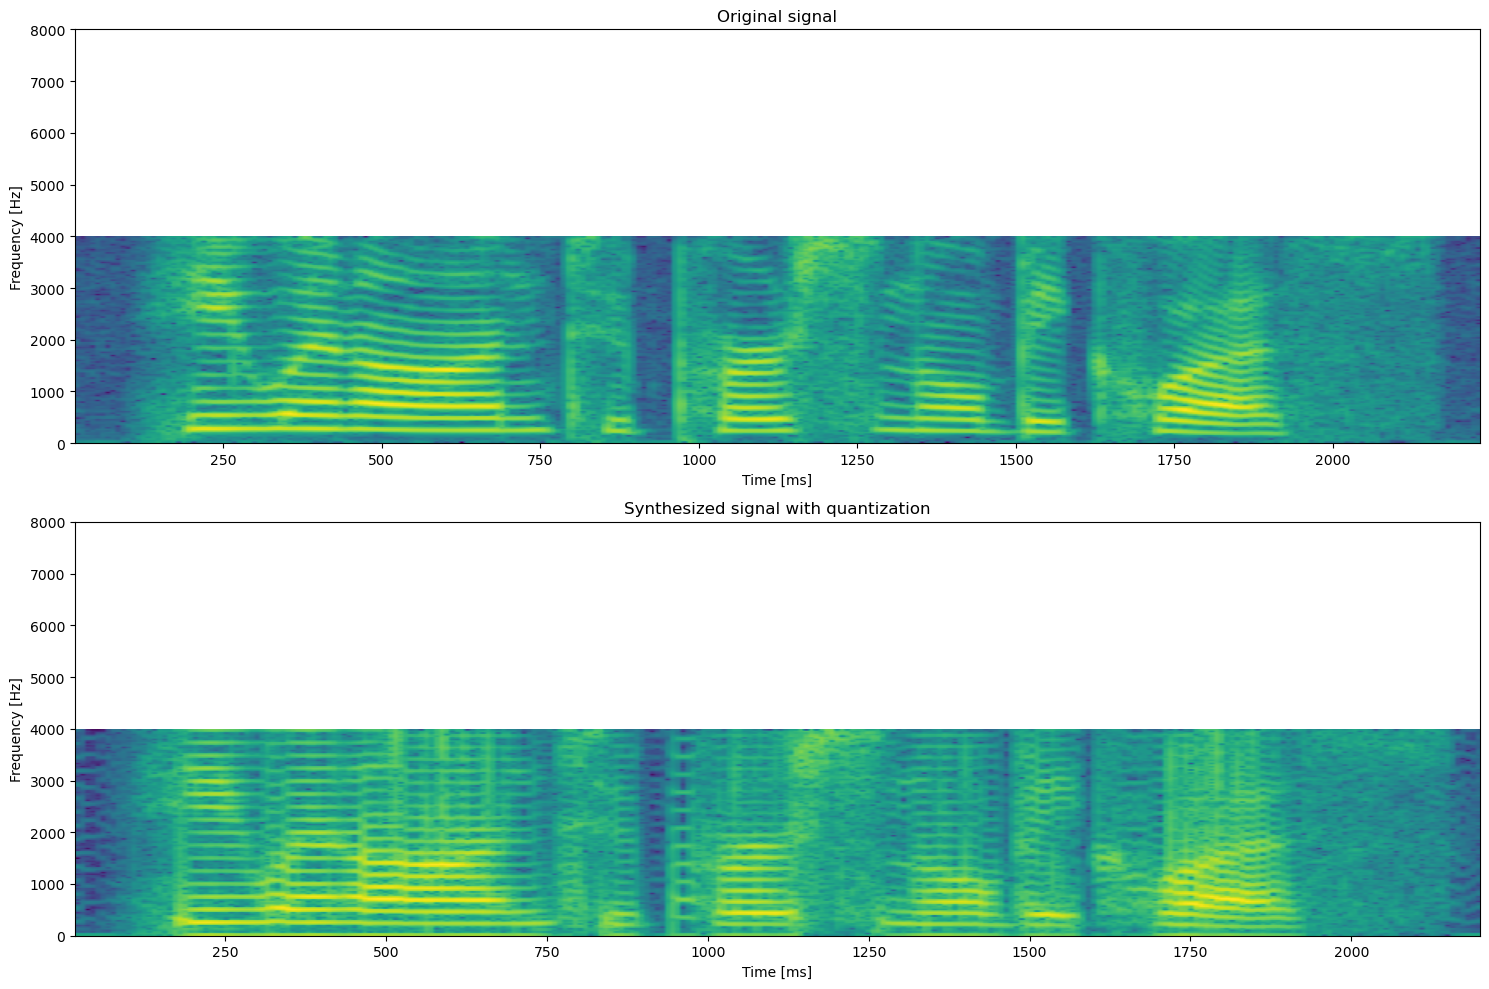

In [68]:
# Spectrogram of original signal and synthesized quantization signal
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_log_spectrogram(x, fs, ax=axs[0])
axs[0].set_title("Original signal")

plot_log_spectrogram(s_synth_quant, fs, ax=axs[1])
axs[1].set_title("Synthesized signal with quantization")

fig.tight_layout()

## Data rate

In [69]:
print(f"""
- For each parameter, how many bits per frame do you need? Per second?
  - 16 bits/frame
  - frame length = 32 ms
  - 16 * 1000 / 32 = {16 * 1000 / 32:.2f} bits/second

- What is the overall bit rate in kbit/second? Also show how you came to your result.
  - overall 16 * 3 = 48 bits/frame
  - 48 * 1000 / 32 = {48 * 1000 / 32} bits/second = {48 * 1000 / 32 / 1000} kbit/second

- What is the bit rate for a direct quantization of the waveform with 16 bit per sample?
  - given 8 kHz sampling rate
  - 16 * 8000 / 1000 = 128 kbit/second

- What is the price to pay for the reduced bit rate?
  - Slightly worse quality
  - Need to encode/decode at both ends
""")


- For each parameter, how many bits per frame do you need? Per second?
  - 16 bits/frame
  - frame length = 32 ms
  - 16 * 1000 / 32 = 500.00 bits/second

- What is the overall bit rate in kbit/second? Also show how you came to your result.
  - overall 16 * 3 = 48 bits/frame
  - 48 * 1000 / 32 = 1500.0 bits/second = 1.5 kbit/second

- What is the bit rate for a direct quantization of the waveform with 16 bit per sample?
  - given 8 kHz sampling rate
  - 16 * 8000 / 1000 = 128 kbit/second

- What is the price to pay for the reduced bit rate?
  - Slightly worse quality
  - Need to encode/decode at both ends



In [70]:
voiced = np.pad(np.repeat(v_voiced.astype(bool), R)
# s_synth_quant[~voiced] = x[~voiced]
s_synth_quant[voiced] = x[voiced]

SyntaxError: '(' was never closed (1915594443.py, line 1)

In [ ]:
Audio(s_synth_quant, rate=fs)

In [ ]:
v_voiced.shape